# ÉCOLE IVADO/Mila EN APPRENTISSAGE PROFOND
# SESSION D'AUTOMNE 2018 
# Tutoriel : Réseaux de neurones récurrents (RNN)



## Auteurs

Francis Grégoire <francis.gregoire@mila.quebec>

Jeremy Pinto <jeremy.pinto@mila.quebec>

Jean-Philippe Reid <Jean-Philippe.Reid@ElementAI.com>

Mirko Bronzi <mirko.bronzi@mila.quebec>

## Préface

Ce tutoriel contient deux exemples ayant comme objectif d'introduire des concepts fondamentaux sur les réseaux neuronaux récurrents (RNN et LSTM).

La première tâche consiste d'un exemple plutôt élémentaire servant à mettre en évidence l'avantage d'utiliser un modèle LSTM contre un simple RNN.

Dans la deuxième tâche, nous allons mettre en valeur un modèle LSTM de manière plus concrète en développant un modèle de langue neuronal pour générer du nouveau texte. Dans cet exemple, vous allez apprendre comment faire le prétraitement des données textuelles dans le but de réussir à entraîner un modèle de langue neuronal de manière efficace.

---
# Initialisation et importation des librairies

Pour assurer le bon fonctionnement de ce notebook sur Colab, il est nécessaire d'installer quelques librairies à l'aide de `pip`. Tout d'abord, assurez-vous d'être connectés au notebook (✓ CONNECTED en haut à droite). Exécutez ensuite la cellule suivante en la sélectionnant et en cliquant `shift`+`Enter`. L'installation peut prendre quelques minutes.

In [0]:
!pip3 install torch torchvision matplotlib

In [0]:
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Seed pour reproduire les résultats.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("PyTorch version: ", torch.__version__)
print("GPU available: {}".format(use_gpu))

PyTorch version:  1.0.1.post2
GPU available: True


---
# Contexte théorique


## Réseaux de neurones récurrents

Un large ensemble de types de données comporte une certaine dimension temporelle non-négligeable. Par exemple, lorsque nous traitons des données textuelles (c.à.d. pour des systèmes de traduction automatique, question-réponse, *chatbots*, etc.), le contexte est souvent un élément important à modéliser afin de correctement faire de bonnes prédictions. Considérons la phrase "*J'aime l'école IVADO/Mila en apprentissage profond (3e édition) parce que les gens de l'équipe Mila transfert technologique sont tellement ... *". En évaluant le contexte de cette phrase, nous pouvons assumer qu'il y a une probabilité plus élevée que le prochain mot soit le mot "*cools*" au lieu du mot "*stupides*".

Les MLP traitent seulement les données à un temps $t$ sans vraiment considérer celles qui se trouvent avant ou après. Ils demandent aussi d'utiliser des variables d'entrées de taille fixe. Dans la situation où nous nous retrouvons avec des données de tailles variables nécessitant une sorte de mécanisme de mémoire intertemporelle, ce type de réseaux de neurones limite souvent nos capacités de modélisation et performent généralement moins bien.

Les réseaux de neurones récurrents (RNN) sont utiles pour traiter les données de tailles variables. Par taille variable, nous voulons dire des données sous la forme de séquences avec un nombre différent d'éléments. Par exemple, deux phrases $\mathbf{s}_{i} = (x_{i,1}, \dots, x_{i,N})$ et $\mathbf{s}_{j} = (x_{j,1}, \dots, x_{j,M})$ n'ont pas la même longueur si $N \neq M$. La couche cachée d'un RNN, aussi appelée état récurrent, que nous dénotons $\mathbf{h}_{t} \in \mathbb R^{d_{h}}$, est un vecteur de dimension $d_{h}$ servant à représenter la mémoire à travers le temps. À chaque pas de temps $t$, l'état récurrent est une fonction récursive qui se met à jour avec en entrée les variables d'entrées actuelles $x_{t}$ et l'état récurrent au pas de temps précédent $\mathbf{h}_{t-1}$. Cette fonction prend la forme:

\begin{equation}
  \mathbf{h_{t}} = f(x_{t}, \mathbf{h}_{t-1})
\end{equation}

et fait en sorte que la sortie du modèle à chaque pas de temps $t$ est dépendant des calculs précédents. La fonction $f(\cdot)$ peut prendre plusieurs formes. Dans le cas d'un RNN classique, nous avons:

\begin{equation}
  f(x_{t}, \mathbf{h}_{t-1}) = g(\mathbf{W}\psi(x_{t}) + \mathbf{U}\mathbf{h}_{t-1} + \mathbf{b}_{h}),
\end{equation}

où $\psi(x_{t})$ peut simplement être la fonction identité (comme dans la tâche 1) ou une fonction qui transforme une donnée discrète en une représentation vectorielle continue de dimension $d_{e}$ (comme dans la tâche 2) . Les matrices $\mathbf{W} \in \mathbb R^{d_{h} \times d_{e}}$ et $\mathbf{U} \in \mathbb R^{d_{h} \times d_{h}}$ sont des paramètres du modèle partagés à chaque pas de temps $t$. Ces matrices déterminent l'importance à accorder à la fois aux données actuelles et à l'état récurrent passé. Enfin, $g(\cdot)$ est une fonction d'activation non-linéaire.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width=800 >

La structure du réseau et le format de la sortie $y$ d'un RNN dépendent de la tâche sous-jacente que nous voulons modéliser. Pour les tâches de classification, l'approche la plus naturelle consiste à utiliser le vecteur du dernier état récurrent afin de produire la sortie désirée. Pour modéliser la sortie, la loi de Bernoulli correspond parfaitement à la classification binaire (où la cible $y \in \{0, 1\}$) pour obtenir la probabilité conditionnelle d'avoir un exemple positif:

\begin{equation}
  p(y_{t} = 1 | \mathbf{h}_{t}) = \sigma(\mathbf{v}^\top \mathbf{h}_{t} + \mathbf{b}_{c}).
\end{equation}

Où $\sigma$ représente la fonction sigmoïde. Lorsque nous traitons un problème de classification multiclasse avec $n$ classes, la couche de sortie contient $n$ neurones et il est donc commun d'utiliser une fonction *softmax* pour nous retourner une distribution catégorique, soit la distribution conditionnelle que la sortie $y \in \{1, \dots, n\}$ définie comme suit:

\begin{equation}
  [p(y_{t} = 1 | \mathbf{h}_{t}), \dots, p(y_{t} = n | \mathbf{h}_{t})]^\top = softmax(\mathbf{V}^\top \mathbf{h}_{t} + \mathbf{b}_{c}),
\end{equation}

où $\mathbf{V} \in \mathbb R^{d_{h} \times d_{y}}$, $\mathbf{v}\ \in \mathbb R^{d_{h}}$ et $\mathbf{b}_{c}\ \in \mathbb R^{d_{y}}$ font partie de l'ensemble des paramètres du modèle.

En théorie, les RNN permettent de modéliser les dépendances pour des séquences arbitrairement longues. En réalité, il est démontré qu'il est difficile d'apprendre des dépendances à long terme durant l'entraînement des paramètres (consultez l'[article de Bengio et al. (1994)](http://ai.dinfo.unifi.it/paolo//ps/tnn-94-gradient.pdf)). Comme un RNN est récursif et que les paramètres sont partagés à travers chaque pas de temps pour une séquence en entrée, en appliquant l'algorithme de rétropropagation du gradient pour l'apprentissage des paramètres du modèle, le gradient $\nabla$ dépend non seulement des calculs au pas de temps actuel, mais aussi aux pas de temps précédents. Pour une séquence de $N$ pas de temps, cela peut avoir comme effet de multiplier $N$ petits nombres pour calculer le gradient, de sorte que sa valeur décroît exponentiellement pour tendre rapidement vers zéro. Le modèle apprend très lentement après quelques pas de temps, voir pas du tout. Cet effet problématique est appelé le *vanishing gradient problem*. De l'autre côté, lorsque nous avons un gradient qui peut prendre des valeurs élevées, nous faisons face au *exploding gradient problem*.

## Long Short Term Memory

Le modèle Long Short Term Memory (LSTM) a été introduit afin de contourner l'*exploding gradient problem* et dans le but de pouvoir construire un RNN capable d’apprendre les dépendances à long terme sur un grand nombre de pas de temps. Aujourd'hui, il s'agit du modèle récurrent le plus utilisé dans les applications d'apprentissage profond en NLP. Un LSTM n'a pas une architecture fondamentalement différente d'un RNN, mais il utilise une fonction différente et plus sophistiquée dans le calcul des états récurrents. Les deux images suivantes montrent la différence entre le mécanisme interne d'un RNN (haut) et d'un LSTM (bas).

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=600 >
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=600 >

Contrairement à un RNN classique, un LSTM sépare la mémoire en deux composantes; l'état de mémoire $\mathbf{c_{t}}$ et l'état récurrent $\mathbf{h_{t}}$. L'état récurrent $\mathbf{h_{t}}$ est un sous-ensemble de l'état de mémoire cachée $\mathbf{c_{t}}$ et seulement ce sous-ensemble est visiblement exposé aux autres parties du réseau. Le LSTM utilise une porte de sortie $\mathbf{o}$ (*output gate*) pour déterminer combien de mémoire révéler à l'état récurrent. La fonction de l'*output gate* est calculée ainsi:

\begin{equation}
  \mathbf{o} = \sigma(\mathbf{W}_{o} \psi(x_{t}) + \mathbf{U}_{o} \mathbf{h}_{t-1} + \mathbf{b}_{o}).
\end{equation}

Ce vecteur est multiplié élément par élement avec l'état de mémoire pour donner l'état récurrent suivant:

\begin{equation}
  \mathbf{h}_{t} = \mathbf{o} \odot tanh(\mathbf{c}_{t}).
\end{equation}

Pour mettre à jour l'état de mémoire, le LSTM utilise une porte d'oublie $\mathbf{f}$ (*forget gate*) et une porte d'entrée $\mathbf{i}$ (*input gate*), de sorte que:

\begin{equation}
  \mathbf{c}_{t} = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{i} \odot \tilde{\mathbf{c}}_{t},
\end{equation}

où $\tilde{\mathbf{c}}_{t}$ est un état de mémoire candidat. La *forget gate* détermine la proportion d'information à oublier de l'état de mémoire, tandis que l'*input gate* contrôle la proportion d'information à garder du nouvel élément en entrée et de l'état récurrent précédent:

\begin{gather}
  \mathbf{f} = \sigma(\mathbf{W}_{f} \psi(x_{t}) + \mathbf{U}_{f} \mathbf{h}_{t-1} + \mathbf{b}_{f}), \\
  \mathbf{i} = \sigma(\mathbf{W}_{i} \psi(x_{t}) + \mathbf{U}_{i} \mathbf{h}_{t-1} + \mathbf{b}_{i}), \\
  \tilde{\mathbf{c}} = tanh(\mathbf{W}_{c} \psi(x_{t}) + \mathbf{U}_{c} \mathbf{h}_{t-1} + \mathbf{b}_{c}).
\end{gather}

Les paramètres $\mathbf{W}_{o}$, $\mathbf{U}_{o}$, $\mathbf{b}_{o}$, $\mathbf{W}_{f}$, $\mathbf{U}_{f}$, $\mathbf{b}_{f}$, $\mathbf{W}_{i}$, $\mathbf{U}_{i}$, $\mathbf{b}_{i}$, $\mathbf{W}_{c}$, $\mathbf{U}_{c}$ et $\mathbf{b}_{c}$ sont des paramètres supplémentaires spécifiques au LSTM et doivent être estimés avec tous les autres paramètres du modèle.

Pour en apprendre plus sur les LSTM, consultez l'[article de Colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (à ne pas confondre avec Colab).


---
# Tâche 1: Sommes de nombres


## Objectif

L'objectif de cet exemple est de construire un modèle capable de faire la somme d'une série de nombres. Il s'agit d'une tâche très simple (une calculatrice de poche peut facilement l'exécuter!) et servira à souligner certaines limitations des RNN. L'ensemble de données est facile à générer et nous permet de rapidement tester la capacité à modéliser une longue séquence entre un RNN traditionnel et un LSTM.



## Ensemble de données

L'ensemble de données est constitué d'un ensemble de séquences de nombres de longueur $seq\_len$ où une cible est associée à chacune. Dans notre cas, la cible d'une séquence est associée à la somme des nombres de la séquence. Ainsi, pour un exemple donné nous avons comme variable d'entrée un vecteur $\mathbf x^{(i)} = \left[x_{1}^{i}, x_{2}^{i}, \dots, x_{T}^{N}\right]$ de longueur $seq\_len=T$ et comme cible la variable $y^{(i)}$ donnée par:

\begin{align}  
y^{(i)}=\sum_{j=1}^{seq\_len}x^{(i)}_j.
\end{align}

Où $j$ est l'indice de temps.

Par exemple, pour un $\mathbf x^{(i)}$ explicitement défini avec $seq\_len=4$, nous avons:


\begin{align}  
\mathbf x^{(i)} &= \left[ 4,-1,15,24\right], \, \mathbf x^{(i)} \in \mathbb R^{4}; \\ 
y^{(i)} &= 42, \, \mathrm y^{(i)} \in \mathbb R.
\end{align}

Nous allons nous servir de cet ensemble de données pour entrainer un RNN et un LSTM. Comme la cible est un nombre réel, nous devons utiliser une couche linéaire pour projeter le dernier état récurrent du RNN/LSTM, $h^{(i)}_{T}$, tel qu'illustré à la figure suivante:

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.002.jpeg)


### Génération d'un ensemble de données

Afin de mieux énoncer la tâche, nous définissons une fonction utilitaire qui nous permet de construire un ensemble de données aléatoires de `n_samples` séquences de longueur `seq_len` en utilisant la fonction [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint).

In [0]:
def generate_data(n_samples, seq_len, input_dim, xmin=-100, xmax=100):
    """Générer des tenseurs X et Y dans l'intervalle [xmin, xmax].
    
    Args : 
      n_samples: int, nombre de séquences à générer.
      seq_len: int, longueur de chaque séquence.
      xmin: valeur minimale que peut prendre n'importe quel nombre d'une séquence.
      xmax: valeur maximale que peut prendre n'imoprte quel nombre d'une séquence.
    
    Returns: retourne les séquences de nombres X et les cibles Y en format 
             torch.FloatTensor où X.shape = (n_samples, seq_len, input_dim) et
             Y.shape = (n_samples, 1).
    """
    
    # À Compléter
    # __START_BLOCK_ANSWER__
    X = torch.randint(xmin, xmax+1, (n_samples, seq_len, input_dim))
    X = X.type(torch.FloatTensor)
    Y = X.sum(dim=1)
    # __END_BLOCK_ANSWER__
    return X, Y


n_samples = 1000
seq_len = 18
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Dimensions du tenseur X = {}".format(X.shape))
print("où n_samples = {}, seq_len = {}, input_dim = {}".format(*X.shape))

Dimensions du tenseur X = torch.Size([1000, 18, 1])
où n_samples = 1000, seq_len = 18, input_dim = 1


La fonction `generate_data()` retourne deux tenseurs `X` et `Y`, où `X` représente l'ensemble des séquences de nombres et `Y` l'ensemble des cibles (c.à.d. la somme des séquences de `X`). Les dimensions de `X` sont égales à `(n_samples, seq_len, input_size)` où `input_size=1` étant donné que la donnée d'entrée à chaque pas de temps est un nombre réel $\in \mathbb R$.

## Préparation des données

Nous allons préparer nos objets DataLoader pour gérer efficacement les ensembles de données que nous allons générer. Pour cet exemple, nous utilisons 20,000 séquences où 80% des données sert comme ensemble d'entraînement, 10% comme ensemble de validation et 10% comme ensemble test.

Utilisez les valeurs suivantes:

`seq_len = 18` 

`batch_size = 64`

`n_samples = 25000`

In [0]:
n_samples = 25000
seq_len = 18
batch_size = 64

X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)

# À Compléter
Xtrain, Ytrain = X[:round(0.8*n_samples)], Y[:round(0.8*n_samples)]
# __NEXT_LINE_ANSWER__
Xvalid, Yvalid = X[round(0.8*n_samples):round(0.9*n_samples)], Y[round(0.8*n_samples):round(0.9*n_samples)]
# __NEXT_LINE_ANSWER__
Xtest, Ytest = X[round(0.9*n_samples):], Y[round(0.9*n_samples):]

### Standardisation des données

Afin d'aider notre modèle lors de l'entraînement, nous standardisons nos données de sorte qu'elles aient une moyenne de 0 et un écart type de 1. Afin de pouvoir retransformer nos données, nous devons conserver les valeurs de la moyenne et de l'écart type employées. 

Note: étant donné que nous échantillonnons à partir d'un ensemble uniformément distribué, l'écart type devrait approcher $\frac{(xmax-xmin)}{\sqrt{12}}$ et la moyenne $\frac{(xmax-xmin)}{2}$.

In [0]:
def get_mean_and_std(X):
    """Cette fonction calcule la moyenne et l'écart-type de X. 
    Args:
      X: torch.Tensor.
    
    Returns:
      mean: torch.Tensor.
      std: torch.Tensor.
    """
    
    # À Compléter
    # __START_BLOCK_ANSWER__
    mean = torch.mean(X)
    std = torch.std(X)
    # __END_BLOCK_ANSWER__
    return mean, std

def standardize(X, Y, mean, std):
    """Cette fonction standardise le tenseur X. 
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      mean: torch.Tensor.
      std: torch.Tensor.
    
    Returns:
      X: torch.Tensor standardisé.
      Y: torch.Tensor, somme du tenseur X.
    """
    
    # À Compléter
    # __START_BLOCK_ANSWER__
    X = (X - mean) / std
    Y = torch.sum(X, dim=1)
    # __END_BLOCK_ANSWER__
    return X, Y

mean, std = get_mean_and_std(X)
Xtrain_std, Ytrain_std = standardize(Xtrain, Ytrain, mean, std)
Xvalid_std, Yvalid_std = standardize(Xvalid, Yvalid, mean, std)
Xtest_std, Ytest_std = standardize(Xtest, Ytest, mean, std)

assert torch.all(torch.eq(Ytrain_std, torch.sum(Xtrain_std, dim=1)))
assert torch.all(torch.eq(Yvalid_std, torch.sum(Xvalid_std, dim=1)))
assert torch.all(torch.eq(Ytest_std, torch.sum(Xtest_std, dim=1)))
print("moyenne = {:.4f}, écart-type = {:.4f}".format(mean, std))

moyenne = 0.1275, écart-type = 58.0333


Nous pouvons utiliser les fonctions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) et [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) afin de préparer les Dataloader

In [0]:
from torch.utils.data import DataLoader, TensorDataset

# À Compléter
train_loader = DataLoader(TensorDataset(Xtrain_std, Ytrain_std),
                          batch_size, shuffle=True)
# __NEXT_LINE_ANSWER__
valid_loader = DataLoader(TensorDataset(Xvalid_std, Yvalid_std), 
                          batch_size, shuffle=False)
# __NEXT_LINE_ANSWER__
test_loader = DataLoader(TensorDataset(Xtest_std, Ytest_std),
                          batch_size, shuffle=False)

## Implémentation d'un RNN

Nous allons définir notre RNN en utilisant la classe [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). Pour plus de détails sur l'implémentation de cette classe, vous pouvez consulter ce [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net). Une fois initialisée, cette classe accepte comme données d'entrées `X` de dimensions `(seq_len, batch_size, input_size)` (avec `input_size=1` dans notre exemple). Nous devons ajouter une couche linéaire pour transformer la prédiction en sortie du RNN dans la même dimension que notre cible `Y` de dimensions `(batch_size, input_size)` (avec `input_size=1` dans notre exemple). 

Pour définir l'architecture de notre RNN, nous utiliserons le module [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn) suivi d'une couche linéaire [torch.nn.Linear()](https://pytorch.org/docs/stable/nn.html#linear). Les méthodes suivantes sont à compléter:
<ul>
<li>La méthode `__init__()` qui définit les couches du modèle. </li>
<li>La méthode `forward()` qui utilise les couches et des variables en entrée pour retourner une sortie (équivalent à une *forward pass*).</li>
</ul>
**Notes importantes**: 

* il peut être déroutant d'obtenir le dernier état récurrent de la dernière couche cachée d'un RNN, $h_{T}^{N}$, où $T$ est le dernier pas de temps et $N$ est la dernière couche cachée. Dans le cas d'un RNN, le dernier état récurrent de la dernière couche cachée peut être obtenu en indexant ces deux tenseurs de cette manière: `output[-1, :, :]` ou `hidden_T[-1]`.

* Vous devez vous assurer que les dimensions de `X` en entrée soient conséquents avec l'implémentation de [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). La fonction [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) peut vous être utile.

In [0]:
class RNNLinear(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        
        # À Compléter
        # __START_BLOCK_ANSWER__
        self.rnn = nn.RNN(input_size,
                          hidden_size,
                          n_layers)
        
        self.linear = nn.Linear(hidden_size, output_size)
        # __END_BLOCK_ANSWER__
        
    def forward(self, x):
        # À Compléter
        # rappel: l'input d'un RNN doit être de dimensions (seq_len, batch_size, input_size)
        # __START_BLOCK_ANSWER__
        x = x.transpose(0, 1) # l'input d'un RNN doit être de dimensions (seq_len, batch_size, input_size)
        output, _ = self.rnn(x)
        pred = self.linear(output[-1])
        # __END_BLOCK_ANSWER__
        return pred
    
    
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Déclarer le modèle RNN.
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# Sauvegarder les poids initiaux du modèle.
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Utiliser le RNN pour faire la prédiction de tous les exemples sans entraînement (c.à.d. sur les n_samples)
# Vérifiez que les inputs d'entrée et sorties sont justes
X = X.to(device)
y_pred = model_rnn(X)
print("Dimensions initiales des données en entrée: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Dimensions des prédictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Dimensions initiales des données en entrée: torch.Size([25000, 18, 1])
Dimensions des prédictions: torch.Size([25000, 1])


## Implémentation d'un LSTM

Nous allons maintenant implémenter un LSTM. Nous utilisons la classe [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Comme avec le RNN, nous devons ajouter une couche linéaire pour transformer la prédiction en sortie du LSTM dans la même dimension que notre cible `Y` de dimensions `(batch_size, input_size)` (avec `input_size=1` dans notre exemple). Pour plus de détails sur l'implémentation de cette classe, consultez ce [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net).

Pour définir l'architecture de notre LSTM, les méthodes suivantes sont à compléter:
<ul>
<li>La méthode `__init__()` qui définit les couches du modèle. </li>
<li>La méthode `forward()` qui utilise les couches et des variables en entrée pour retourner une sortie (équivalent à une forward pass).</li>
</ul>

**Notes importantes**: 

*  il peut être déroutant d'obtenir le dernier état récurrent de la dernière couche cachée d'un LSTM, $h_{T}^{N}$, où $T$ est le dernier pas de temps et $N$ est la dernière couche cachée. Dans le cas d'un LSTM, le dernier état récurrent de la dernière couche cachée peut être obtenu en indexant ces tenseurs de cette manière: `output[-1, :, :]` ou `hidden_T[0][-1]`.

* Vous devez vous assurer que les dimensions de `X` en entrée soient conséquents avec l'implémentation de [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn).

In [0]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        # À Compléter
        # __START_BLOCK_ANSWER__
        
        self.LSTM = nn.LSTM(input_size,
                            hidden_size,
                            n_layers)
        
        self.linear = nn.Linear(hidden_size, output_size)
        # __END_BLOCK_ANSWER__
        
    def forward(self, x):
        # À Compléter
        # rappel: l'input d'un RNN doit être de dimensions (seq_len, batch_size, input_size)
        # __START_BLOCK_ANSWER__
        x = x.transpose(0, 1) # l'input d'un LSTM doit être de dimensions (seq_len, batch_size, input_size)
        output, _ = self.LSTM(x)
        pred = self.linear(output[-1])
        # __END_BLOCK_ANSWER__
        return pred
    

input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Déclarer le modèle LSTM.
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# Sauvegarder les poids initiaux du modèle.
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Utiliser le LSTM pour faire la prédiction de tous les exemples sans entraînement(c.à.d. sur les n_samples)
# Vérifiez que les inputs d'entrée et sorties sont justes

X = X.to(device)
y_pred = model_lstm(X)
print("Dimensions initiales des données en entrée: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Dimensions des prédictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Dimensions initiales des données en entrée: torch.Size([25000, 18, 1])
Dimensions des prédictions: torch.Size([25000, 1])


## Entraînement du RNN

De nombreuses fonctions de coût et optimiseurs sont disponibles dans PyTorch. Dans cet exemple, nous utilisons l'erreur quadratique moyenne (voir [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)).

### Définir la fonction de coût et l'optimiseur

Rappelons qu'une fonction de coût $J(\theta) = L(x, y, \theta)$ prend en entrée le tuple (prédiction, cible) et calcule une valeur qui estime la distance entre la prédiction et la cible. L'optimiseur que nous utilisons dans cet exemple est celui de la descente de gradient stochastique (*stochastic gradient descent* (SGD)), minimise la fonction de coût $J(\theta)$ paramétrisée par les poids du modèle $\theta$ en mettant à jour les poids itérativement suivant la règle de mise à jour suivante: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, où  $\alpha$ est le taux d'apprentissage (*learning rate*).

Pour un problème de régression comme nous avons dans cet exemple, un choix commun est d'utiliser les fonctions suivantes :
<ul>
<li>**Fonction de coût :** <a href="https://pytorch.org/docs/stable/nn.html">`torch.nn.MSELoss()`</a>. L'erreur quadratique moyenne permet de calculer la moyenne de l'écart au carré entre la valeur prédite et la valeur désirée. Cette fonction est définie comme:

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.
    
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> qui est une implémentation de Stochastic Gradient Descent.</li>
</ul>

Nous utilisons une valeur de taux d'apprentissage de 0.001.

In [0]:
# À Compléter
learning_rate = 0.001
# __NEXT_LINE_ANSWER__
criterion = nn.MSELoss()
# __NEXT_LINE_ANSWER__
optimizer = optim.SGD(model_rnn.parameters(), lr=learning_rate)

### Entraînement du modèle

Nous utilisons notre objet `train_loader` pour itérer à travers notre ensemble d'entraînement *n_epoch* fois pour faire l'entraînement du modèle. La valeur accumulée de la fonction de coût évaluée sur l'ensemble de validation est sauvegardée à la fin de chaque *epoch* d'entraînement.

In [0]:
since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Start training")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    # __START_BLOCK_ANSWER__
    model_rnn.train()
    # __END_BLOCK_ANSWER__
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device
        # __START_BLOCK_ANSWER__
        x = x.to(device)
        y = y.to(device)
        # __END_BLOCK_ANSWER__

        # Zero the gradient buffer
        # __START_BLOCK_ANSWER__
        optimizer.zero_grad()
        # __END_BLOCK_ANSWER__
        
        # Forward
        # __NEXT_LINE_ANSWER__
        outputs = model_rnn(x)
        
        # Calculate loss
        # __NEXT_LINE_ANSWER__
        loss = criterion(outputs, y)
        
        # Backward
        # __START_BLOCK_ANSWER__
        loss.backward()
        # __END_BLOCK_ANSWER__
        
        # Optimize
        # __START_BLOCK_ANSWER__
        optimizer.step()
        # __END_BLOCK_ANSWER__
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    # __START_BLOCK_ANSWER__
    model_rnn.eval()
    # __END_BLOCK_ANSWER__
    
    # Iterate over valid data
    for x, y in valid_loader:  
        
        # Put tensors on device (GPU if available)
        # __START_BLOCK_ANSWER__
        x = x.to(device)
        y = y.to(device)
        # __END_BLOCK_ANSWER__
        
        # Forward
        # __NEXT_LINE_ANSWER__
        outputs = model_rnn(x)
        # __NEXT_LINE_ANSWER__
        loss = criterion(outputs, y)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Start training
Epoch  1 | Training loss = 11.46495 | Validation loss = 7.91993 
Epoch  2 | Training loss = 4.00827 | Validation loss = 2.24049 
Epoch  3 | Training loss = 2.82316 | Validation loss = 2.79560 
Epoch  4 | Training loss = 2.20248 | Validation loss = 1.54188 
Epoch  5 | Training loss = 1.77194 | Validation loss = 1.91442 
Epoch  6 | Training loss = 1.69183 | Validation loss = 0.76953 
Epoch  7 | Training loss = 1.57370 | Validation loss = 2.87059 
Epoch  8 | Training loss = 1.38248 | Validation loss = 1.18059 
Epoch  9 | Training loss = 1.41712 | Validation loss = 1.87618 
Epoch 10 | Training loss = 1.34616 | Validation loss = 0.69853 
Epoch 11 | Training loss = 1.16281 | Validation loss = 1.32467 
Epoch 12 | Training loss = 1.06112 | Validation loss = 2.26369 
Epoch 13 | Training loss = 1.09434 | Validation loss = 0.60840 
Epoch 14 | Training loss = 1.00203 | Validation loss = 0.61354 
Epoch 15 | Training loss = 0.98979 | Validation loss = 1.08526 
Epoch 16 | Training loss

### Visualisation des courbes d'entraînement

Visualisez les courbes d'entraînement avec un graphique mettant en valeur la fonction de cout vs. le nombre d'époque pour l'ensemble d'entraînement et de validation sur un même graphe.

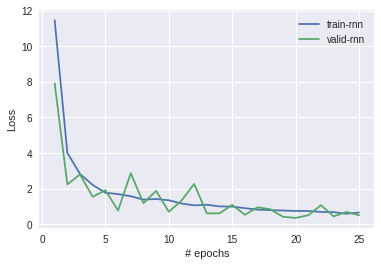

In [0]:
# Save history for later
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Entraînement LSTM

### Définir la fonction de coût et l'optimiseur

Rappelons qu'une fonction de coût $J(\theta) = L(x, y, \theta)$ prend en entrée le tuple (prédiction, cible) et calcule une valeur qui estime la distance entre la prédiction et la cible. L'optimiseur que nous utilisons dans cet exemple est celui de la descente de gradient stochastique (*stochastic gradient descent* (SGD)), minimise la fonction de coût $J(\theta)$ paramétrisée par les poids du modèle $\theta$ en mettant à jour les poids itérativement suivant la règle de mise à jour suivante: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, où  $\alpha$ est le taux d'apprentissage (*learning rate*).

Pour un problème de régression comme nous avons dans cet exemple, un choix commun est d'utiliser les fonctions suivantes :
<ul>
<li>**Fonction de coût :** <a href="https://pytorch.org/docs/stable/nn.html">`torch.nn.MSELoss()`</a>. L'erreur quadratique moyenne permet de calculer la moyenne de l'écart au carré entre la valeur prédite et la valeur désirée. Cette fonction est définie comme:

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.
    
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> qui est une implémentation de SGD.</li>
</ul>

Nous utilisons une valeur de taux d'apprentissage de 0.01.

In [0]:
# __NEXT_LINE_ANSWER__
criterion = nn.MSELoss()
# __NEXT_LINE_ANSWER__
optimizer = optim.SGD(model_lstm.parameters(), lr=0.01)

### Entraînement du model

Nous utilisons notre objet `train_loader` pour itérer à travers notre ensemble d'entraînement *n_epoch* fois pour faire l'entraînement du modèle. La valeur accumulée de la fonction de coût évaluée sur l'ensemble de validation est sauvegardée à la fin de chaque *epoch* d'entraînement.

In [0]:
since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    # __START_BLOCK_ANSWER__
    model_lstm.train()
    # __END_BLOCK_ANSWER__
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device
        # __START_BLOCK_ANSWER__
        x = x.to(device)
        y = y.to(device)
        # __END_BLOCK_ANSWER__

        # Zero the gradient buffer
        # __START_BLOCK_ANSWER__
        optimizer.zero_grad()
        # __END_BLOCK_ANSWER__
        
        # Forward
        # __NEXT_LINE_ANSWER__
        outputs = model_lstm(x)
        
        # Calculate loss
        # __NEXT_LINE_ANSWER__
        loss = criterion(outputs, y)
        
        # Backward
        # __START_BLOCK_ANSWER__
        loss.backward()
        # __END_BLOCK_ANSWER__
        
        # Optimize
        # __START_BLOCK_ANSWER__
        optimizer.step()
        # __END_BLOCK_ANSWER__
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    # __START_BLOCK_ANSWER__
    model_lstm.eval()
    # __END_BLOCK_ANSWER__
    
    # Iterate over valid data
    for x, y in valid_loader:  
        
        # Put tensors on device (GPU if available)
        # __START_BLOCK_ANSWER__
        x = x.to(device)
        y = y.to(device)
        # __END_BLOCK_ANSWER__
        
        # Forward
        # __NEXT_LINE_ANSWER__
        outputs = model_lstm(x)
        # __NEXT_LINE_ANSWER__
        loss = criterion(outputs, y)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #
Epoch  1 | Training loss = 14.33293 | Validation loss = 4.25235 
Epoch  2 | Training loss = 2.82861 | Validation loss = 0.85709 
Epoch  3 | Training loss = 1.02309 | Validation loss = 0.39077 
Epoch  4 | Training loss = 0.59925 | Validation loss = 0.24543 
Epoch  5 | Training loss = 0.49440 | Validation loss = 0.20843 
Epoch  6 | Training loss = 0.32500 | Validation loss = 0.51041 
Epoch  7 | Training loss = 0.28413 | Validation loss = 0.11878 
Epoch  8 | Training loss = 0.25689 | Validation loss = 0.10381 
Epoch  9 | Training loss = 0.25658 | Validation loss = 0.43236 
Epoch 10 | Training loss = 0.20162 | Validation loss = 0.19366 
Epoch 11 | Training loss = 0.16294 | Validation loss = 0.23086 
Epoch 12 | Training loss = 0.15836 | Validation loss = 0.23869 
Epoch 13 | Training loss = 0.16358 | Validation loss = 0.09006 
Epoch 14 | Training loss = 0.11876 | Validation loss = 0.18644 
Epoch 15 | Training loss = 0.10137 | Validation loss = 0.04167 
Epoch 16 | Training 

### Visualisation des courbes d'entraînement

Visualisez les courbes d'entraînement avec un graphique mettant en valeur la fonction de coût vs. le nombre d'époques pour l'ensemble d'entraînement et de validation sur un même graphe.

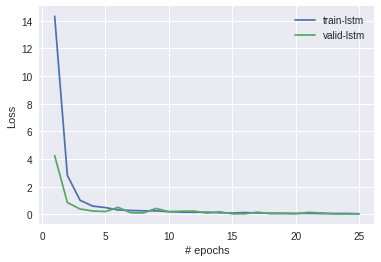

In [0]:
# Save history for later
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, num_epochs + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Analyse des résultats

Analysons l'erreur générée par notre modèle sur notre ensemble test.  Nous allons comparer l'erreur quadratique moyenne sur l'ensemble test pour le modèle RNN et LSTM.

### Comparaisons des courbes d'entraînenement

Nous allons comparer sur un même graphique l'erreur en fonction du nombre d'epochs lors de notre entraînement sur nos ensembles d'entraînement et de validation.

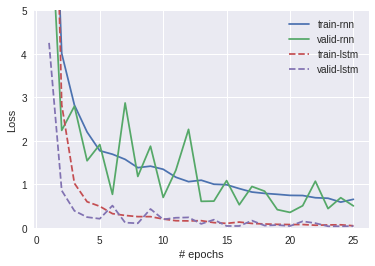

In [0]:
# Plot training and validation curve
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0,5])
plt.show()

Remarquez qu'il y a une différence entre les résultats des RNN et des LSTM.

**Questions**

*   Quel réseau fonctionne mieux sur notre ensemble validation? Pourquoi?
*   Quelle est la différence majeure entre les deux réseaux?
*   Qu'est-ce qui fait qu'une courbe d'entraînement est plus ou moins lisse qu'une autre?



### Calcul de l'erreur sur l'ensemble test

Calculez l'erreur quadratique moyenne sur l'ensemble test pour les RNN et les LSTM et imprimez les deux valeurs.

In [0]:
# Put data on gpu
# __NEXT_LINE_ANSWER__
Xtest_std = Xtest_std.to(device)
# __NEXT_LINE_ANSWER__
Ytest_std = Ytest_std.to(device)

# __NEXT_LINE_ANSWER__
Ypred_rnn = model_rnn(Xtest_std)
# __NEXT_LINE_ANSWER__
Ypred_lstm = model_lstm(Xtest_std)

# __NEXT_LINE_ANSWER__
loss_test_rnn = criterion(Ypred_rnn, Ytest_std)
# __NEXT_LINE_ANSWER__
loss_test_lstm = criterion(Ypred_lstm, Ytest_std)


print("L'erreur quadratique moyenne des RNN sur l'ensemble test (standardisé) est de %2.3f" % float(loss_test_rnn))
print("L'erreur quadratique moyenne des LSTM sur l'ensemble test (standardisé) est de %2.3f" % float(loss_test_lstm))

L'erreur quadratique moyenne des RNN sur l'ensemble test (standardisé) est de 0.493
L'erreur quadratique moyenne des LSTM sur l'ensemble test (standardisé) est de 0.036



**Questions**

*   Est-ce que les résultats sur l'ensemble test sont comparables à ceux sur l'ensemble validation?


### Vérification visuelle des résultats

Nous définissons une fonction `print_sequence()` qui aidera à visualiser les prédictions faites par nos modèles. Cette fonction prend en entrée les tenseurs X et Y pour échantillonner et imprimer un exemple de séquence ainsi que la différence absolue entre une valeur de Y et la valeur réelle de la somme de X.

Afin de reconstruire nos exemples, il faut réutiliser `mean` + `std` tel que $xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$


In [0]:
def print_sequence(X, Y, idx=0):
    """Imprimer et vérifier les séquences d'opérations.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: indice de la séquence à vérifier.
    """
    x = X[idx].numpy()
    y = Y[idx].numpy()
    for i, xi in enumerate(x):
        if i==0:
            string = str(xi[0]) 
        else:
            string += " + " + str(xi[0])
    string1 = string + " = " + str(y[0])
    string2 = string + " = " + str(np.sum(x))
    print("Prédiction: ", string1)
    print("Valeur réelle: ", string2)
    ecart = abs(np.sum(x)-y[0])
    print("Écart absolu entre X[{a}] et Y[{a}]: {b}".format(a=idx, b=ecart))

In [0]:
Xtest_std_cpu = Xtest_std.cpu()
Ypred_rnn_cpu = Ypred_rnn.cpu()

# __NEXT_LINE_ANSWER__
Xtest_unstd = Xtest_std_cpu * std + mean
# __NEXT_LINE_ANSWER__
Ypred_rnn_unstd = Ypred_rnn_cpu * std + seq_len * mean

idx = np.random.randint(len(Ytest))


print("")
print("Exemple RNN:")
print("")

print_sequence(Xtest_unstd.detach(), Ypred_rnn_unstd.detach(), idx=idx)
Ypred_lstm_cpu = Ypred_lstm.cpu()
Ypred_lstm_unstd = Ypred_lstm_cpu * std + seq_len * mean

print("")
print("Exemple LSTM:")
print("")

print_sequence(Xtest_unstd.detach(), Ypred_lstm_unstd.detach(), idx=idx)


Exemple RNN:

Prédiction:  35.0 + -56.0 + 25.0 + -82.0 + 23.0 + 71.0 + 94.0 + -2.0 + -30.999998 + 56.0 + 69.0 + -59.0 + 1.0 + -77.0 + -72.0 + 75.0 + 14.0 + 11.0 = 66.53608
Valeur réelle:  35.0 + -56.0 + 25.0 + -82.0 + 23.0 + 71.0 + 94.0 + -2.0 + -30.999998 + 56.0 + 69.0 + -59.0 + 1.0 + -77.0 + -72.0 + 75.0 + 14.0 + 11.0 = 95.0
Écart absolu entre X[1914] et Y[1914]: 28.46392059326172

Exemple LSTM:

Prédiction:  35.0 + -56.0 + 25.0 + -82.0 + 23.0 + 71.0 + 94.0 + -2.0 + -30.999998 + 56.0 + 69.0 + -59.0 + 1.0 + -77.0 + -72.0 + 75.0 + 14.0 + 11.0 = 92.233406
Valeur réelle:  35.0 + -56.0 + 25.0 + -82.0 + 23.0 + 71.0 + 94.0 + -2.0 + -30.999998 + 56.0 + 69.0 + -59.0 + 1.0 + -77.0 + -72.0 + 75.0 + 14.0 + 11.0 = 95.0
Écart absolu entre X[1914] et Y[1914]: 2.7665939331054688


** Questions bonus**

* Que pouvez-vous suggérer comme techniques et modifications pour améliorer la performance des LSTM?
* Répétez l'exercice pour différentes opérations mathématiques (+, -, x, /, ...)
* Faites un graphique comparant la performance des RNN et LSTM en fonction de `seq_len`

---
# Tâche 2: Modèle de langue neuronal


## Objectif
L'objectif de cette tâche est d'utiliser un petit ensemble des oeuvres de l'écrivain et philosophe [Voltaire](https://fr.wikipedia.org/wiki/Voltaire) dans le but d'essayer de recréer des textes s'inspirant de son style à l'aide des réseaux de neurones récurrents. 

Le modèle employé est un peu plus complexe que celui de la tâche précédente. Nous avons fait le prétraitement d'un corpus et dans cette exercice nous allons faire le traitement des données pour qu'elles soient utilisables dans un modèle de langue neuronal à base de LSTM. Nous vous invitons donc à lire les sections suivantes pour vous aider à comprendre la logique du code, toutefois il n'y a pas de code à remplir dans cet exercice. Il s'agit plutôt d'un exemple concret d'un modèle génératif qui démontre la capacité des réseaux de neurones récurrents avec une tâche divertissante.

Vous pouvez vous servir de ce code pour entraîner un modèle de langue sur les différents corpus de vos artistes ou auteurs préférés. L'important, c'est de comprendre les concepts de base fondamentaux du traitement de texte, de la modélisation et de l'entraînement d'un LSTM. Bonne lecture!

## Encore un peu de contexte théorique (car vous aimez vraiment ça)

Une séquence de mots $\mathbf{s}$ peut être représentée comme une séquence de $N$ symboles discrets (ou unités lexicales) tel que $\mathbf{s} = (w_{1}, \dots, w_{N})$, où $w_{t}$ est un mot ou un symbole de ponctuation. Chacun de ces symboles est aussi représenté par un nombre entier équivalent à l'indice de sa position dans le vocabulaire $V$ contenant les symboles d'un langage. L'objectif d'un modèle de langue est d'estimer la probabilité conjointe d'une séquence $p(\mathbf{s}) = p(w_{1}, \dots, w_{N})$, que nous pouvons décomposer en un produit de probabilités conditionnelles, telle que:

\begin{equation}
  p(\mathbf{s}) = \prod^{N}_{t=1} p(w_{t} | w_{1}, \dots, w_{t-1}).
\end{equation}

De tels modèles de langue sont utilisés dans de nombreuses applications, telles que la traduction automatique, la reconnaissance de la parole et la recherche d'information. En réalité, cette distribution n'est pas définie et il n'est pas trivial de l'estimer. Une manière de réduire considérablement la difficulté de ce problème de modélisation consiste à assumer que les mots les plus près dans une séquence sont statistiquement plus dépendants que les mots plus éloignés. C'est en appliquant la propriété de Markov d'ordre $n-1$ qu'un modèle de langue statistique de type $n$-gramme nous permet d'approximer la distribution conditionnelle d'un symbole étant donné les $n-1$ symboles précédents, de sorte que:

\begin{equation}
  p(w_{t} | w_{1}, \dots, w_{t-1}) \approx p(w_{t} | w_{t-n+1}, \dots, w_{t-1}).
\end{equation}

Pour entraîner un modèle de langue, nous sommes obligés d'utiliser un corpus où la grande majorité des séquences de mots plausibles dans une langue n'apparaissent pas. Autrement dit, nous devons estimer une distribution sur un ensemble infiniment petit par rapport à l'espace de toutes les séquences de mots d'un langage. Cela fait en sorte que les modèles de langue statistiques ne généralisent pas nécessairement de manière efficace. D'un autre côté, plus un modèle de langue statistique est entraîné sur un grand corpus, plus la taille du vocabulaire augmente. En revanche, le nombre de séquences de symboles possibles augmente exponentiellement plus la taille du vocabulaire est grande, causant le problème de malédiction de la dimension (*curse of dimensionality*) dû à la rareté d'observation des séquences.

Pour alléger ces deux problèmes fondamentaux, [l'article de Bengio et al. (2003)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) propose un modèle de langue neuronal qui utilise un réseau de neurones comme approximateur de la probabilité conditionnelle $p(w_{t} | w_{t-n+1}, \dots, w_{t-1})$, où chaque symbole du vocabulaire est représenté par un vecteur de nombres réels continus. Comme les données en entrée d'un réseau de neurones doivent être sous format matriciel, chaque symbol $w_{t}$ se trouvant dans le vocabulaire est représenté par un vecteur *one-hot* $\mathbf{x}_{i}$ dans lequel toutes les valeurs sont égales à 0, sauf pour la valeur à l'indice $i$ (l'indice du symbole $w_{t}$ dans le vocabulaire $V$) qui est égale à 1. Ces vecteurs *one-hot* sont multipliés par une matrice de poids, $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$, qui fait partie des paramètres à apprendre, appelée matrice d'*embeddings*, afin d'obtenir des représentations vectorielles continues, $\mathbf{w}_{t} \in \mathbb R^{d_{e}}$, qui servent d'entrées à un réseau de neurones.

Une séquence de mots peut alors être représentée par une séquence de $N$ vecteurs $\mathbf{s} = (\mathbf{w}_{1}, \dots, \mathbf{w}_{N})$. Nous pouvons voir chaque ligne $i$ de la matrice $\mathbf{E}$ comme la représentation dans un espace vectoriel de dimension $d_{e}$ correspondant au $i$-ième symbole du vocabulaire $V$. Ces représentations sont souvent appelées *word embeddings*. Lorsqu'elles sont apprises sur un corpus assez grand, elles arrivent à représenter la similarité sémantique basée sur la propriété distributionnelle entre les différents symboles du vocabulaire.

L'architecture du modèle de langue neuronal que nous allons utiliser est un LSTM qui définit une séquence de mots en une distribution de probabilité conditionnelle. Pour l'entraînement des paramètres, nous devons déterminer le nombre des $n-1$ mots précédents (`seq_len` dans code) à utiliser pour estimer $p(w_{t} | w_{t-n+1}, \dots, w_{t-1})$. Les entrées du LSTM à chaque pas de temps $t$ est le *word embedding* correspondant au $t$-ième mot de la sèquence ainsi que l'état récurrent et l'état mémoire au pas de temps précédent, qui sont respectivement $\mathbf{h}_{t-1}$ et $\mathbf{c}_{t-1}$. Il est important de préciser que nous utilisons un modèle autorégressif où le mot en entrée au pas de temps $t$ est le mot utilisé en sortie pour le pas de temps $t-1$ du LSTM. Cela nous permet de générer des séquences une fois que le modèle est entraîné. Ce type de modèle est couramment appelé *LSTM-based neural language model* et son architecture est présentée à la figure ci-dessous (avec des caractères comme unité lexicale au lieu des mots).

![alt-text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/RNN/images/autoregressive_french.png?raw=true)

Pour calculer la distribution de probabilité de sortie, nous utilisons la fonction *softmax* qui retourne un vecteur de dimension $|V|$ (la taille du vocabulaire) en garantissant des probabilités de sorties positives sommant à 1.

## Fonctions utilitaires de traitement de texte et structuration des données

Pour faire l'apprentissage de notre modèle de langue neuronal nous allons utiliser un corpus qui est un regroupement de quatre oeuvres littéraires du grand écrivain et philosophe Voltaire que nous avons nettoyé, tokenisé et standardisé pour vous (fichier `voltaire.txt`).

En pratique, pour obtenir des résultats intéressants nous devons entraîner un modèle de langue sur une très grande quantité de texte. Pour des raisons pratico-pratiques, dans ce tutoriel nous utilisons un corpus de petite taille composé de 12,363 phrases, 182,163 tokens et un vocabulaire de 15,558 tokens. Un token est une unité lexicale séparée par un *whitespace* de chaque côté dans le texte. Dans notre cas, un token est un mot, un nombre ou un symbole de ponctuation. Le vocabulaire est l'ensemble des différents tokens d'un corpus (souvent trié en fonction du nombre d'occurences des tokens). Bien que notre ensemble d'entraînement est petit, le code suivant est facilement réutilisable avec n'importe quel autre corpus de votre choix.

In [0]:
# Cloner git repos pour accéder aux corpus voltaire.txt.
!git clone https://github.com/mila-iqia/ecole_dl_mila_ivado.git

Cloning into 'ecole_dl_mila_ivado'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 269 (delta 15), reused 28 (delta 11), pack-reused 232
Receiving objects: 100% (269/269), 4.20 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [0]:
START_VOCAB = ["_UNK"]
UNK_ID = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def create_vocabulary(corpus_path, vocab_path, max_vocab_size=1e5):
    """Créer et sauvegarder le vocabulaire d'un corpus."""
    vocab = {}
    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                if token in vocab:
                    vocab[token] += 1
                else:
                    vocab[token] = 1
    vocab_list = START_VOCAB + sorted(vocab, key=vocab.get, reverse=True)
    if len(vocab_list) > max_vocab_size:
        vocab_list = vocab_list[:max_vocab_size]
    with open(vocab_path, "w", encoding="utf-8") as f:
        for token in vocab_list:
              f.write(token + "\n")


def initialize_vocabulary(vocab_path):
    """Initialiser le vocabulaire."""
    if os.path.exists(vocab_path):
        with open(vocab_path, "r", encoding="utf-8") as f:
            rev_vocab = [line.strip() for line in f.readlines()]
        vocab = dict([(w, i) for (i, w) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Vocabulary file {} not found.".format(vocab_path))


def read_corpus(corpus_path):
    """Lire et convertir un corpus en une liste de tokens."""
    with open(corpus_path, "r", encoding="utf-8") as f:
        corpus = f.read().split()
    return corpus


def corpus_to_token_ids(corpus, vocab):
    """Convertir un corpus en token-ids."""
    token_ids = [vocab.get(token, UNK_ID) for token in corpus]
    return token_ids


def batch_data(data, batch_size):
    """Structurer les données en batch_size séquences continues."""
    n_batch = len(data) // batch_size
    data = np.array(data[:n_batch*batch_size])
    data = data.reshape(batch_size, -1).T
    return data


def detach_hidden(hidden):
    """Transformer les données des états cachés d'un LSTM en
       nouveaux Tensor avec require_grad=False."""
    return tuple(h.detach() for h in hidden)

In [0]:
# Créer et initialiser le vocabulaire.
corpus_path = "./ecole_dl_mila_ivado/tutoriaux/RNN/data/voltaire.txt"
vocab_path = "vocab.txt"

create_vocabulary(corpus_path, vocab_path)
vocab, rev_vocab = initialize_vocabulary(vocab_path)

# Lire le corpus d'entraînement.
corpus = read_corpus(corpus_path)
token_ids = corpus_to_token_ids(corpus, vocab)

# Structurer le corpus en batch_size séquences continues pour faire l'entraînement.
batch_size = 10
data = batch_data(token_ids, batch_size)
data = torch.LongTensor(data).to(DEVICE)

print("Nombre de tokens dans le corpus: {}"
      .format(len(corpus)), end="\n\n")
print("Taille du vocabulaire: {}"
      .format(len(vocab)), end="\n\n")
print("Liste des 20 tokens les plus fréquents dans le corpus: \n{}"
      .format(rev_vocab[1:21]), end="\n\n")
print("Première phrase du corpus en format texte:\n{}"
      .format(" ".join(corpus[:31])), end="\n\n")
print("Première phrase du corpus transformée en token-ids:\n{}"
      .format(token_ids[:31]), end="\n\n")
print("Test de conversion token-ids vers texte en utilisant rev_vocab:\n{}"
      .format(" ".join([rev_vocab[i] for i in token_ids[:31]])), end="\n\n")
print("Structure des données d'entraînement (observez que la première phrase "
      "est dans la première colonne):\n{}".format(data[:20]))

Nombre de tokens dans le corpus: 182163

Taille du vocabulaire: 15558

Liste des 20 tokens les plus fréquents dans le corpus: 
[',', 'de', '.', 'et', 'la', 'le', 'les', ';', "l'", 'il', 'à', 'un', 'que', 'en', "d'", 'des', 'qui', 'est', "qu'", 'dans']

Première phrase du corpus en format texte:
il y avait en Westphalie , dans le château de M. le baron de Thunder-ten-tronckh , un jeune garçon à qui la nature avait donné les moeurs les plus douces .

Première phrase du corpus transformée en token-ids:
[10, 52, 65, 14, 1452, 1, 20, 6, 401, 2, 188, 6, 331, 2, 1453, 1, 12, 263, 2650, 11, 17, 5, 180, 65, 559, 7, 953, 7, 31, 2266, 3]

Test de conversion token-ids vers texte en utilisant rev_vocab:
il y avait en Westphalie , dans le château de M. le baron de Thunder-ten-tronckh , un jeune garçon à qui la nature avait donné les moeurs les plus douces .

Structure des données d'entraînement (observez que la première phrase est dans la première colonne):
tensor([[   10,  4318,    10,    87,    49

In [0]:
# Split ensembles training/validation et créer DataLoaders.
X = data[:-1]
Y = data[1:]

n_valid = round(data.size(0) * 0.1)
train_set = TensorDataset(X[:(data.size(0)-n_valid)], Y[:(data.size(0)-n_valid)])
valid_set = TensorDataset(X[-n_valid:], Y[-n_valid:])

seq_len = 40
train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=seq_len, shuffle=False)

print("Ensemble d'entraînement: {} séquences de longueur {} et {} minibatches"
      .format(len(train_set), seq_len, len(train_loader)))
print("Ensemble de validation : {} séquences de longueur {} et {} minibatches"
      .format(len(valid_set), seq_len, len(valid_loader)))

Ensemble d'entraînement: 16394 séquences de longueur 40 et 410 minibatches
Ensemble de validation : 1822 séquences de longueur 40 et 46 minibatches


## Implémentation du modèle

Ci-dessous se trouve le code du *LSTM-based neural language model* décrit dans la section **Encore un peu de contexte théorique (car vous aimez vraiment ça)**.

À chaque pas temps les variables d'entrées dans le LSTM sont une minibatch de séquences de token-ids (c.à.d. des séquences d'indices où chaque indice représente la position d'un token dans un vocabulaire) et des tuples $(\mathbf{h}_{0}, \mathbf{c}_{0})$ des états récurrents et des états mémoires équivalent aux $(\mathbf{h}_{T}, \mathbf{c}_{T})$ de la minibatch précédente (sauf pour la première minibatch où nous initialisons les valeurs de ces variables à 0.0 avec la fonction `init_hidden()`).

Chaque séquence de token-ids est transformée en séquence de *word embeddings* en indexant les représentations *word embeddings* créés par la classe [torch.nn.Embedding()](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) qui est une matrice de paramètres de dimension $|V| \times d_{e}$, où $|V|$ est la taille du vocabulaire (`vocab_size`) et $d_{e}$ est la dimension d'un *word embedding* (`embedding_size`).

Nous appliquons du dropout sur les *word embeddings* en entrée et sur la couche de sortie pour régulariser le modèle.

In [0]:
class LanguageModel(nn.Module):
    """Modèle de langue neuronal à base de LSTM."""
    
    def __init__(self, vocab_size, input_size, hidden_size, n_layers=1, dropout=0.5):
        """
        Args:
          vocab_size: taille du vocabulaire.
          input_size: taille des word embeddings.
          hidden_size: taille des états cachés du LSTM.
          n_layers: nombre de couches du LSTM (default: 1).
          dropout: si non-zéro, introduit une couche dropout à l'entrée et à la sortie
                   du LSTM, avec une probabilité égale à dropout (default: 0.5).
        """        
        super(LanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embeddings = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            n_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input, hidden):
        embeddings = self.dropout(self.embeddings(input))
        output, hidden = self.lstm(embeddings, hidden)
        output = self.dropout(output)
        result = self.linear(output.view(output.size(0)*output.size(1), output.size(2)))
        return result.view(output.size(0), output.size(1), result.size(1)), hidden

    def init_weights(self):
        init.uniform_(self.embeddings.weight, -0.1, 0.1)
        init.xavier_uniform_(self.linear.weight, init.calculate_gain("linear"))
        init.constant_(self.linear.bias, 0)
        
    def init_hidden(self, batch_size):
        """Initialiser les valeurs de l'état caché et la cellule du LSTM à zéro.
        Args:
          batch_size: taille de la mini-batch à un pas de temps.
          
        Returns:
          hidden: état caché h_t et la cellule c_t à t=0 initialisés à 0, 
                  ((n_layers, batch_size, hidden_size),
                   (n_layers, batch_size, hidden_size)).
        """
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE))
        return hidden

## Entraînement du modèle
L'entraînement du modèle se fait presque de la même manière que dans la tâche 1. Les éléments clés différents sont les suivants:
* Nous appliquons du dropout sur les *word embeddings* en entrée et la couche de sortie du LSTM. Étant donné que la taille de notre ensemble d'entraînement est très petite, il est alors facile pour notre modèle de faire du surapprentissage. Pour les modéles génératifs autorégressifs à base de RNN, il est fortement recommandé d'utiliser une probabilité dropout élevée pour éviter l'effet de surapprentissage des données.
* Nous démarrons l'entraînement avec une valeur de `learning_rate` élevée et nous la diminuons par un facteur de 10 en fonction de la perte sur l'ensemble de validation évaluée à la fin de chaque *epoch* d'entraînement en utilisant la classe [torch.optim.lr_scheduler.ReduceLROnPlateau()](https://pytorch.org/docs/stable/optim.html?highlight=plateau#torch.optim.lr_scheduler.ReduceLROnPlateau).
* Pour éviter le *exploding gradient problem*, nous appliquons la technique de *gradient clipping* en normalisant la norme du gradient avec la fonction [torch.nn.utils.clip_grad_norm_()](https://pytorch.org/docs/stable/nn.html?highlight=clip#torch.nn.utils.clip_grad_norm_).
* Nous initialisons avec des valeurs de 0.0 le tuple $(\mathbf{h}_{0}, \mathbf{c}_{0})$ de l'état récurrent et l'état mémoire `hidden` avec la fonction `init_hidden()` uniquement une fois au début de chaque *epoch* d'entraînement et nous propageons les nouvelles valeurs de `hidden` à travers chaque minibatch d'entraînement. En d'autres mots, les données ont été structurées à l'aide de la fonction `batch_data()` de manière à ce que nous pouvons initialiser `hidden` $(\mathbf{h}_{0}, \mathbf{c}_{0})$ de chaque séquence d'une nouvelle minibatch par $(\mathbf{h}_{T}, \mathbf{c}_{T})$ de la minibatch précédente. Un désavantage de cette méthode est que nous ne pouvons pas mélanger l'ordre des séquences à chaque *epoch* d'entraînement (c.à.d. `train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)`).
* Notre fonction de coût est l'entropie croisée [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss).
* Nous présentons la mesure de *[perplexity](https://en.wikipedia.org/wiki/Perplexity)* qui est une mesure d'évaluation de la qualité d'un modèle de langue.

In [0]:
# Construire le modèle.
vocab_size = len(vocab)
embedding_size = 300
hidden_size = 400
n_layers = 1
dropout = 0.65
model = LanguageModel(vocab_size, embedding_size, hidden_size, n_layers, dropout).to(DEVICE)
print("Nombre de paramètres dans le modèle:", sum(param.nelement() for param in model.parameters()))

# Fonction de coût et optimiseur.
learning_rate = 10
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

# Entraînement du modèle.
n_epochs = 20
max_grad_norm = 1

print("Entraînement du modèle pour {} epochs de {} minibatches".format(n_epochs, len(train_loader)))
for epoch in range(n_epochs):
    model.train()
    hidden = model.init_hidden(batch_size)
    train_loss = 0
    valid_loss = 0
    for x, y in train_loader:
        # Détacher les états cachés précédents du graphe computationnel.
        hidden = detach_hidden(hidden)
        
        # Réinitialiser le gradient.
        optimizer.zero_grad()
                
        # Forward pass.
        y_pred, hidden = model(x, hidden)
        
        # Calculer la perte.
        loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
        
        # Calculer le gradient.
        loss.backward()
        
        # Normaliser le gradient pour éviter explosion.
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # Mettre à jour les paramètres du modèle.
        optimizer.step()        
        
        # Accumuler la perte total.
        train_loss += len(x) * loss.item()
    
    # Évaluer le modèle sur l'ensemble de validation.
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(batch_size)
        for x, y in valid_loader:
            y_pred, hidden = model(x, hidden)
            loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
            valid_loss += len(x) * loss.item()
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    scheduler.step(valid_loss)

    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} | Perplexity = {:.2f}"
          .format(epoch+1, train_loss, valid_loss, np.exp(valid_loss)))
print("Félicitations! Vous avez terminé d'entraîner votre beau modèle de langue neuronal!")

Nombre de paramètres dans le modèle: 12029358
Entraînement du modèle pour 20 epochs de 410 minibatches
Epoch  1 | Training loss = 6.74891 | Validation loss = 6.09639 | Perplexity = 444.25
Epoch  2 | Training loss = 5.97263 | Validation loss = 5.77989 | Perplexity = 323.72
Epoch  3 | Training loss = 5.70216 | Validation loss = 5.60305 | Perplexity = 271.25
Epoch  4 | Training loss = 5.52347 | Validation loss = 5.49926 | Perplexity = 244.51
Epoch  5 | Training loss = 5.38915 | Validation loss = 5.43819 | Perplexity = 230.03
Epoch  6 | Training loss = 5.27813 | Validation loss = 5.39166 | Perplexity = 219.57
Epoch  7 | Training loss = 5.18441 | Validation loss = 5.35205 | Perplexity = 211.04
Epoch  8 | Training loss = 5.09746 | Validation loss = 5.33155 | Perplexity = 206.76
Epoch  9 | Training loss = 5.02327 | Validation loss = 5.30559 | Perplexity = 201.46
Epoch 10 | Training loss = 4.94999 | Validation loss = 5.30510 | Perplexity = 201.36
Epoch 11 | Training loss = 4.88538 | Validation

## Génération de texte

Maintenant que nous avons entraîné notre modèle de langue, nous pouvons l'utiliser pour générer du texte dans la langue du grand Voltaire! Pour se faire, nous allons sélectionner aléatoirement un token de notre vocabulaire que nous utilisons comme premier token en entrée, puis nous utiliserons le token en sortie comme prochain token généré et aussi comme token en entrée à la prochaine itération. Nous répétons ensuite cette étape pour un nombre défini de tokens que nous cherchons à générer (`n_words`). La variable `smoothing` permet de lisser les poids des tokens à échantillonner. Une valeur plus élevée donnera un texte avec une plus grande diversité de vocabulaire, mais une valeur trop élevée rendra le texte illisible. Vous pouvez exécuter la cellule suivante à nouveau pour obtenir des textes différents.

In [0]:
# Génération de séquences de mots.
model.eval()
x = torch.randint(0, vocab_size, (1, 1), dtype=torch.long, device=DEVICE)
words = [rev_vocab[x]]
n_words = 300
smoothing = 0.7
with torch.no_grad(): 
    hidden = model.init_hidden(1)
    for i in range(n_words-1):
        output, hidden = model(x, hidden)
        weights = output.squeeze().div(smoothing).exp()
        word_idx = torch.multinomial(weights, 1)
        x.fill_(word_idx.squeeze())
        word = rev_vocab[word_idx]
        words.append(word)
        if (i+1) % 15 == 0:
            words.append("\n")
print(" ".join(words))

dévorait sa pique . pour l' amour , qui sera le mal de l' amour et 
 la guerre , et l' Amour , pour avoir des tours d' Espagne , et 
 d' un air d' oeil , sur un mouvement nommé , qui va un jour 
 , mais on en reçut à la porte les réponses et les jacobites ; et 
 le peuple se présentèrent de l' avis . on dit qu' il y avait un 
 peu de tête ; il s' arrêta dans la cervelle dans les murs de son 
 père . il est très vrai que tout , le bon ciel étant toujours volé 
 , et qui le fait tomber de son visage , et de l' estomac à 
 la terre ; de la société on se mit à Jeanne : « Mon cher 
 maître ! quelle état ! quelles mystères ! vous voulez passer les dépouilles des ruisseaux 
 de notre monnaie , que je vous sais , si je suis persuadé que vous 
 ne vous dirai pas ; je ne sais qu' il y a des maximes et 
 de la mer , et à la fin de Dieu , ce qui est fait 
 pour lui dans ce beau château , il ne le trouve qu' une mascarade d' 
 esprit . c' est une nouvelle qui peut faire le plus vite , qui l' 
 a ét

Qu'en pensez-vous? À première vue, bien que certaines séquences de mots peuvent être cocasses, la clarté du texte généré n'est pas la meilleure. En effet, nous observons que la virgule (`,`) apparaît souvent dans le texte et cela est dû au fait que la virgule s'agit du token le plus fréquent dans notre corpus (rappelez-vous que les 10 tokens les plus fréquents sont `[',', 'de', '.', 'et', 'la', 'le', 'les', ';', "l'", 'il']`. Pour améliorer la clarté du texte généré, il serait nécessaire d'entraîner le modèle sur un corpus de plus grande taille. De plus, nous soulignons que le vocabulaire et le style littéraire de notre cher Voltaire ne sont pas les plus conventionnels! Au final, il ne faut pas oublier que nous avons simplement appris une distribution de probabilité basée sur les statistiques d'un corpus.

---
## Références
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://arxiv.org/abs/1803.08240